<a href="https://colab.research.google.com/github/amandeep0/BA-2021/blob/main/kmeans-text.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import urllib.request
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
import gensim
from gensim.models import LdaModel
from gensim import models, corpora, similarities
import re
from nltk.stem.porter import PorterStemmer
import time
from nltk import FreqDist
from scipy.stats import entropy
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')


In [3]:
url_1 = "http://gutenberg.ca/ebooks/hemingwaye-sunalsorises/hemingwaye-sunalsorises-00-t.txt"
file_1 = urllib.request.urlopen(url_1)

url_2 = "http://gutenberg.ca/ebooks/hemingwaye-menwithoutwomen/hemingwaye-menwithoutwomen-00-t.txt"
file_2 = urllib.request.urlopen(url_2)

url_3 = "http://gutenberg.ca/ebooks/hemingwaye-acrosstheriver/hemingwaye-acrosstheriver-00-t.txt"
file_3 = urllib.request.urlopen(url_3)

url_4 = "http://gutenberg.ca/ebooks/hemingwaye-oldmanandthesea/hemingwaye-oldmanandthesea-00-t.txt"
file_4 = urllib.request.urlopen(url_4)

files = [file_1, file_2, file_3, file_4]



In [4]:
ids = []
texts = []
id = 0
for file in files:
  doc_len = 0
  document_text = ""
  for line in file:
    formatted_string = str(line.strip())[1:]
    if len(formatted_string) < 20:
      continue
    document_text = document_text + formatted_string  
    doc_len = doc_len + 1
    if doc_len == 50:
      ids.append(id)
      texts.append(document_text)
      document_text = ""
      doc_len = 0

  id = id + 1

df = pd.DataFrame({'id': ids, 'text':texts})



In [5]:
df

,id,text
0,0,'* A Project Gutenberg Canada Ebook *''This eb...
1,0,'of inferiority and shyness he had felt on bei...
2,0,"'very forceful, and Cohn never had a chance of..."
3,0,"'""You forgot to get your paper,"" I said.''""Tha..."
4,0,"'""None of your exalted connections getting div..."
...,...,...
354,3,"'Now they have beaten me, he thought. I am to..."
355,3,"'others too, he thought. I live in a good tow..."
356,3,"'fight again, he thought. I hope so much I do..."
357,3,'sailed up onto the little patch of shingle be...


In [6]:
year_df = pd.DataFrame({'id':[0,1,2,3], 'year':[1926, 1927,1950,1952]})
year_df.head()

,id,year
0,0,1926
1,1,1927
2,2,1950
3,3,1952


In [7]:
import re
# Remove punctuation
df['book_text_processed'] = df['text'].map(lambda x: re.sub('[\',.!?*]', '', str(x)))
# Convert the titles to lowercase
df['book_text_processed'] = df['book_text_processed'].replace(r'\n',' ', regex=True) 
df['book_text_processed'] = df['book_text_processed'].map(lambda x: x.lower())
# Print out the first rows of papers
df['book_text_processed'] = df['book_text_processed'].apply(lambda x: x.strip())
df.head()



,id,text,book_text_processed
0,0,'* A Project Gutenberg Canada Ebook *''This eb...,a project gutenberg canada ebook this ebook is...
1,0,'of inferiority and shyness he had felt on bei...,of inferiority and shyness he had felt on bein...
2,0,"'very forceful, and Cohn never had a chance of...",very forceful and cohn never had a chance of n...
3,0,"'""You forgot to get your paper,"" I said.''""Tha...","""you forgot to get your paper"" i said""that\s s..."
4,0,"'""None of your exalted connections getting div...","""none of your exalted connections getting divo..."


In [8]:
df['book_text_processed'].iloc[0]

'a project gutenberg canada ebook this ebook is made available at no cost and with very fewrestrictions these restrictions apply only if (1) you makea change in the ebook (other than alteration for differentdisplay devices) or (2) you are making commercial use ofthe ebook if either of these conditions applies pleasecheck gutenbergca/links/licencehtml before proceedingthis work is in the canadian public domain but may beunder copyright in some countries if you live outside canada"check your countrys copyright laws if the book is under"copyright in your country do not downloador redistribute this filetitle: the sun also risesauthor: hemingway ernest (1899-1961)date of first publication: 1926edition used as base for this ebook:"new york: charles scribners sons"[undated but no earlier than 1954the date of the copyright renewal]date first posted: 4 july 2015date last updated: 4 july 2015project gutenberg canada ebook #1257this ebook was produced bymarcia brooks al haines paulina chin mark a

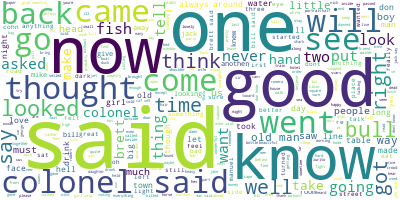

In [9]:
from wordcloud import WordCloud
# Join the different processed titles together.
long_string = ','.join(list(df['book_text_processed'].values))
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()


# K means



In [10]:
!python -m textblob.download_corpora


[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package conll2000 to /root/nltk_data...
[nltk_data]   Unzipping corpora/conll2000.zip.
[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Unzipping corpora/movie_reviews.zip.
Finished.


In [11]:
df

,id,text,book_text_processed
0,0,'* A Project Gutenberg Canada Ebook *''This eb...,a project gutenberg canada ebook this ebook is...
1,0,'of inferiority and shyness he had felt on bei...,of inferiority and shyness he had felt on bein...
2,0,"'very forceful, and Cohn never had a chance of...",very forceful and cohn never had a chance of n...
3,0,"'""You forgot to get your paper,"" I said.''""Tha...","""you forgot to get your paper"" i said""that\s s..."
4,0,"'""None of your exalted connections getting div...","""none of your exalted connections getting divo..."
...,...,...,...
354,3,"'Now they have beaten me, he thought. I am to...",now they have beaten me he thought i am too o...
355,3,"'others too, he thought. I live in a good tow...",others too he thought i live in a good townhe...
356,3,"'fight again, he thought. I hope so much I do...",fight again he thought i hope so much i do no...
357,3,'sailed up onto the little patch of shingle be...,sailed up onto the little patch of shingle bel...


In [12]:
from textblob import TextBlob

def textblob_tokenizer(str_input):
    blob = TextBlob(str_input.lower())
    tokens = blob.words
    words = [token.stem() for token in tokens] #ending ended -> end
    return words

count_vectorizer = CountVectorizer(tokenizer=textblob_tokenizer)
count_data = count_vectorizer.fit_transform(df['book_text_processed'])
pd.DataFrame(count_data.toarray(), columns=count_vectorizer.get_feature_names())


,1,100678,1030,11,1100,118of,12,1257thi,1300,1302thi,1305,1335,1700,17th,183260,1899-1961,1905,1909,1918,1925,1926edit,1927,1927edit,1942,1950edit,1952,1952date,1952edit,1954the,1st,2,201,2012date,2012project,2015date,2015project,2016date,2016project,20th,21,...,yourheart,yourluggag,yourposit,yourself,yoursmi,yoursshe\l,yourtemp,yourth,yourtrad,yourun,yourwif,youse,yousmok,yousom,yousometh,youstop,youth,youthat,youthink,youththeir,youto,youv,youviol,youwant,youwer,youwhat,youwil,youwould,yucatan,yuhh,zelli,zigzag,zinc,zizi,zonda,zurito,zuritobehind,zuritomanuel,zuritopul,zuritoth
0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
355,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
356,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
357,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [14]:
import nltk
nltk.download('words')
words = set(nltk.corpus.words.words())
df['book_text_processed'] = df['book_text_processed'].apply(lambda x: " ".join(w for w in nltk.wordpunct_tokenize(x) if w.lower() in words ))
#df['book_text_processed'] = df['book_text_processed'].apply(lambda x: " ".join(w for w in nltk.wordpunct_tokenize(x) if w.lower() in words or not w.isalpha()))


[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!


In [15]:
df

,id,text,book_text_processed
0,0,'* A Project Gutenberg Canada Ebook *''This eb...,a project canada this is made available at no ...
1,0,'of inferiority and shyness he had felt on bei...,of inferiority and shyness he had felt on bein...
2,0,"'very forceful, and Cohn never had a chance of...",very forceful and never had a chance of not be...
3,0,"'""You forgot to get your paper,"" I said.''""Tha...",you forgot to get your paper i said that s so ...
4,0,"'""None of your exalted connections getting div...",none of your exalted getting no listen jake if...
...,...,...,...
354,3,"'Now they have beaten me, he thought. I am to...",now they have beaten me he thought i am too ol...
355,3,"'others too, he thought. I live in a good tow...",too he thought i live in a good could not talk...
356,3,"'fight again, he thought. I hope so much I do...",fight again he thought i hope so much i do not...
357,3,'sailed up onto the little patch of shingle be...,sailed up onto the little patch of shingle bel...


In [16]:
df['num_unique_words'] = df['book_text_processed'].apply(lambda x: len(np.unique(x.split(" "))))

In [17]:
df = pd.merge(df, year_df, on='id',how='left')

In [18]:
df

,id,text,book_text_processed,num_unique_words,year
0,0,'* A Project Gutenberg Canada Ebook *''This eb...,a project canada this is made available at no ...,141,1926
1,0,'of inferiority and shyness he had felt on bei...,of inferiority and shyness he had felt on bein...,212,1926
2,0,"'very forceful, and Cohn never had a chance of...",very forceful and never had a chance of not be...,196,1926
3,0,"'""You forgot to get your paper,"" I said.''""Tha...",you forgot to get your paper i said that s so ...,225,1926
4,0,"'""None of your exalted connections getting div...",none of your exalted getting no listen jake if...,199,1926
...,...,...,...,...,...
354,3,"'Now they have beaten me, he thought. I am to...",now they have beaten me he thought i am too ol...,205,1952
355,3,"'others too, he thought. I live in a good tow...",too he thought i live in a good could not talk...,208,1952
356,3,"'fight again, he thought. I hope so much I do...",fight again he thought i hope so much i do not...,211,1952
357,3,'sailed up onto the little patch of shingle be...,sailed up onto the little patch of shingle bel...,191,1952


In [19]:
import seaborn as sns

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



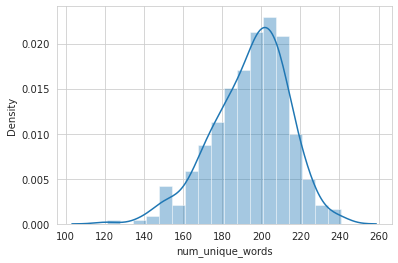

In [20]:
sns.distplot(df['num_unique_words'])

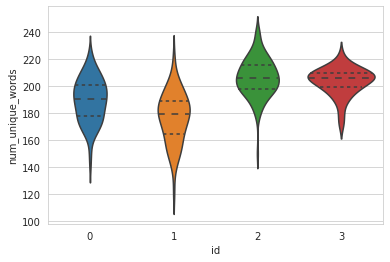

In [21]:
sns.violinplot(x="id", y="num_unique_words", data=df, split=True, inner='quartile')

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


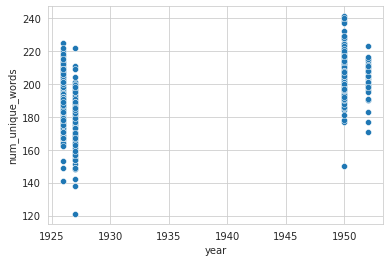

In [ ]:
sns.scatterplot('year', 'num_unique_words', data = df)

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:132: UserWarning: The handle <matplotlib.patches.Patch object at 0x7fdc630e11d0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  figlegend = self.fig.legend(handles, labels, **kwargs)


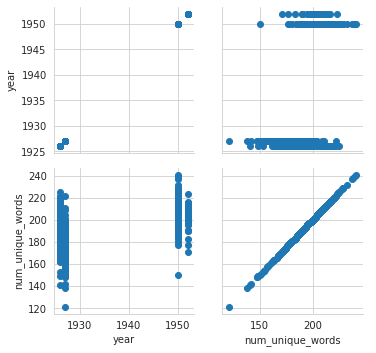

In [ ]:
g = sns.PairGrid(df, vars = ['year',  'num_unique_words'],  palette='RdBu_r')
g.map(plt.scatter)
g.add_legend()

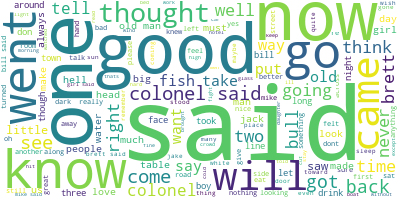

In [22]:
from wordcloud import WordCloud
# Join the different processed titles together.
long_string = ','.join(list(df['book_text_processed'].values))
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

In [23]:
from textblob import TextBlob

def textblob_tokenizer(str_input):
    blob = TextBlob(str_input.lower())
    tokens = blob.words
    words = [token.stem() for token in tokens]
    return words

count_vectorizer = CountVectorizer(tokenizer=textblob_tokenizer)
count_data = count_vectorizer.fit_transform(df['book_text_processed'])
pd.DataFrame(count_data.toarray(), columns=count_vectorizer.get_feature_names())


,a,abandon,abid,abl,abli,abnorm,aboard,about,abov,abox,abruptli,absent,absinth,absolut,absorb,absorpt,abstractli,abut,academi,accent,accept,accid,accident,acclam,accompani,accomplish,accord,accordingli,accordion,account,accur,accus,ace,acetylen,ach,acknowledg,acold,acquir,acrobat,across,...,worthi,worthless,would,wouldnt,wound,wrap,wrapper,wrath,wreath,wreck,wrench,wretch,wrinkl,wrist,write,writer,written,wrong,wrote,y,yacht,yard,ye,yeah,year,yell,yellow,yesterday,yet,york,you,youd,young,younger,your,yourself,youth,youv,zigzag,zinc
0,4,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,4,0,0,0,2,0,0,0,0,0
1,19,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0
2,15,0,0,0,0,0,0,3,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,3,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,5,0,0,0,0,0,0,0,0,0
3,11,0,0,0,0,0,0,2,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,10,0,0,0,1,0,0,0,0,0
4,12,0,0,0,0,1,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,21,0,0,0,3,2,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0
355,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,...,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,11,0,0,0,2,0,0,0,0,0
356,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,...,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0
357,9,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,2,0,0,0,0,0,0,0,0,0


## Term frequency is given by: 
## Term Frequency Formula 
$tf(w,d) = log(1 + f(w,d))$ 

##Here f(w,d) is the frequency of word w in document d.
## Second step is to calculate the inverse term frequency.
## Inverse Document Frequency Formula
$idf(w, D) = log(\frac{N}{f(w,D)})$

## With N documents in the dataset and f(w, D) the frequency of word w in the whole dataset, this number will be lower with more appearances of the word in the whole dataset.
## Final step is to compute the TF-IDF score by the following formula:

$TF-IDF = tf*idf$

In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer

vec = TfidfVectorizer(tokenizer=textblob_tokenizer,
                      stop_words='english',
                      norm='l2', 
                      use_idf=False)
matrix = vec.fit_transform(df['book_text_processed'])
lf = pd.DataFrame(matrix.toarray(), columns=vec.get_feature_names())
lf


/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'thi', 'thu', 'togeth', 'twelv', 'twenti', 'veri', 'wa', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] not in stop_words.



,abandon,abid,abl,abli,abnorm,aboard,abov,abox,abruptli,absent,absinth,absolut,absorb,absorpt,abstractli,abut,academi,accent,accept,accid,accident,acclam,accompani,accomplish,accord,accordingli,accordion,account,accur,accus,ace,acetylen,ach,acknowledg,acold,acquir,acrobat,act,action,activ,...,worri,wors,worship,worst,worth,worthi,worthless,wouldnt,wound,wrap,wrapper,wrath,wreath,wreck,wrench,wretch,wrinkl,wrist,write,writer,written,wrong,wrote,y,yacht,yard,ye,yeah,year,yell,yellow,yesterday,york,youd,young,younger,youth,youv,zigzag,zinc
0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.072548,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.072548,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0
1,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.035714,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.035714,0.0,0.0,0.000000,0.035714,0.0,0.035714,0.0,0.0,0.000000,0.0,0.0
2,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.043519,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.043519,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.043519,0.0,0.0,0.0,0.043519,0.0,0.0,0.0,0.000000,0.0,0.043519,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0
3,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.043602,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.087204,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0
4,0.0,0.0,0.0,0.0,0.043234,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.086468,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.043234,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.043234,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.081992,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.040996,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0
355,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.046575,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0
356,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0

In [25]:
from sklearn.feature_extraction.text import TfidfVectorizer

vec = TfidfVectorizer(tokenizer=textblob_tokenizer,
                      stop_words='english',
                      norm='l2', 
                      use_idf=True)
matrix = vec.fit_transform(df['book_text_processed'])
lf = pd.DataFrame(matrix.toarray(), columns=vec.get_feature_names())
lf

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'thi', 'thu', 'togeth', 'twelv', 'twenti', 'veri', 'wa', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] not in stop_words.



,abandon,abid,abl,abli,abnorm,aboard,abov,abox,abruptli,absent,absinth,absolut,absorb,absorpt,abstractli,abut,academi,accent,accept,accid,accident,acclam,accompani,accomplish,accord,accordingli,accordion,account,accur,accus,ace,acetylen,ach,acknowledg,acold,acquir,acrobat,act,action,activ,...,worri,wors,worship,worst,worth,worthi,worthless,wouldnt,wound,wrap,wrapper,wrath,wreath,wreck,wrench,wretch,wrinkl,wrist,write,writer,written,wrong,wrote,y,yacht,yard,ye,yeah,year,yell,yellow,yesterday,york,youd,young,younger,youth,youv,zigzag,zinc
0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.087425,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.067160,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0
1,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.049098,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.049601,0.0,0.0,0.000000,0.052430,0.0,0.045248,0.0,0.0,0.00000,0.0,0.0
2,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.070004,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.112852,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.061223,0.0,0.0,0.0,0.066112,0.0,0.0,0.0,0.000000,0.0,0.065424,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0
3,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.063667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.125792,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0
4,0.0,0.0,0.0,0.0,0.099259,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.121904,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.032396,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.07284,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.104897,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.091395,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0
355,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.065667,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0
356,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000

In [26]:
from sklearn.cluster import KMeans
cost =[] 
for i in range(1, 11): 
    KM = KMeans(n_clusters = i, max_iter = 500) 
    KM.fit(matrix) 
      
    # calculates squared error 
    # for the clustered points 
    cost.append(KM.inertia_)      


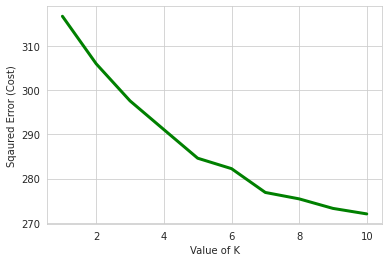

In [27]:
plt.plot(range(1, 11), cost, color ='g', linewidth ='3') 
plt.xlabel("Value of K") 
plt.ylabel("Sqaured Error (Cost)") 
plt.show() # clear the plot 


In [44]:
from sklearn.cluster import KMeans

number_of_clusters=4
km = KMeans(n_clusters=number_of_clusters)
# Normally people fit the matrix
km.fit(matrix)
# But you could fit the idf_df instead
km.fit


<bound method KMeans.fit of KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)>

In [45]:
df['labels'] = km.labels_

In [47]:
zf = (df.groupby(['id','labels']).size()/df.groupby(['id']).size()).reset_index(name ='accuracy')
zf.groupby('id')['accuracy'].max().reset_index(name='accuracy')


,id,accuracy
0,0,0.721311
1,1,0.445946
2,2,0.933884
3,3,1.000000


In [31]:
matrix.shape

(359, 4472)

In [48]:
from sklearn.decomposition import TruncatedSVD
sklearn_svd = TruncatedSVD(n_components = 2)
Y_sklearn = sklearn_svd.fit_transform(matrix)
df['Z_1'] = Y_sklearn[:,0]
df['Z_2'] = Y_sklearn[:,1]


In [49]:
from sklearn.decomposition import TruncatedSVD
sklearn_svd = TruncatedSVD(n_components = 3)
Y_sklearn = sklearn_svd.fit_transform(matrix)


In [52]:
df['Z_1'] = Y_sklearn[:,0]
df['Z_2'] = Y_sklearn[:,1]
df['Z_3'] = Y_sklearn[:,2]

In [53]:
from sklearn.cluster import KMeans

number_of_clusters=4
svd_km = KMeans(n_clusters=number_of_clusters)
svd_km.fit(Y_sklearn)
df['svd_labels'] = svd_km.labels_


In [54]:
zf = (df.groupby(['id','svd_labels']).size()/df.groupby(['id']).size()).reset_index(name ='accuracy')
zf.groupby('id')['accuracy'].max().reset_index(name='accuracy')


,id,accuracy
0,0,0.532787
1,1,0.635135
2,2,0.942149
3,3,0.928571


In [55]:
zf.sort_values('accuracy',inplace=True, ascending=False)
zf

,id,svd_labels,accuracy
6,2,0,0.942149
10,3,3,0.928571
4,1,2,0.635135
0,0,1,0.532787
1,0,2,0.409836
3,1,1,0.202703
5,1,3,0.162162
9,3,2,0.071429
2,0,3,0.057377
7,2,2,0.049587


In [56]:
id_map = {}
hash_done = {}
for _,row in zf.iterrows():
  if row['svd_labels'] in id_map:
    continue
  else:
    id_map[row['svd_labels']] = row['id']  

In [57]:
map_df = pd.DataFrame({'id':map(int, list(id_map.values())),'transformed_id':map(int,list(id_map.keys()))})
map_df

,id,transformed_id
0,2,0
1,3,3
2,1,2
3,0,1


In [58]:
plot_df = pd.merge(df,map_df,on='id',how='inner')
plot_df

,id,text,book_text_processed,num_unique_words,year,labels,Z_1,Z_2,svd_labels,Z_3,transformed_id
0,0,'* A Project Gutenberg Canada Ebook *''This eb...,a project canada this is made available at no ...,141,1926,0,0.102132,-0.056231,2,0.036330,1
1,0,'of inferiority and shyness he had felt on bei...,of inferiority and shyness he had felt on bein...,212,1926,0,0.256232,-0.067937,2,0.131356,1
2,0,"'very forceful, and Cohn never had a chance of...",very forceful and never had a chance of not be...,196,1926,1,0.425377,0.114971,1,-0.086646,1
3,0,"'""You forgot to get your paper,"" I said.''""Tha...",you forgot to get your paper i said that s so ...,225,1926,0,0.315012,-0.027434,2,0.089250,1
4,0,"'""None of your exalted connections getting div...",none of your exalted getting no listen jake if...,199,1926,1,0.406730,0.182087,1,-0.092514,1
...,...,...,...,...,...,...,...,...,...,...,...
354,3,"'Now they have beaten me, he thought. I am to...",now they have beaten me he thought i am too ol...,205,1952,0,0.278364,-0.159163,3,0.288981,3
355,3,"'others too, he thought. I live in a good tow...",too he thought i live in a good could not talk...,208,1952,0,0.321857,-0.132931,3,0.209348,3
356,3,"'fight again, he thought. I hope so much I do...",fight again he thought i hope so much i do not...,211,1952,0,0.272222,-0.121248,3,0.194675,3
357,3,'sailed up onto the little patch of shingle be...,sailed up onto the little patch of shingle bel...,191,1952,0,0.305682,-0.109934,3,0.273976,3


In [59]:
plot_df.columns

Index(['id', 'text', 'book_text_processed', 'num_unique_words', 'year',
       'labels', 'Z_1', 'Z_2', 'svd_labels', 'Z_3', 'transformed_id'],
      dtype='object')

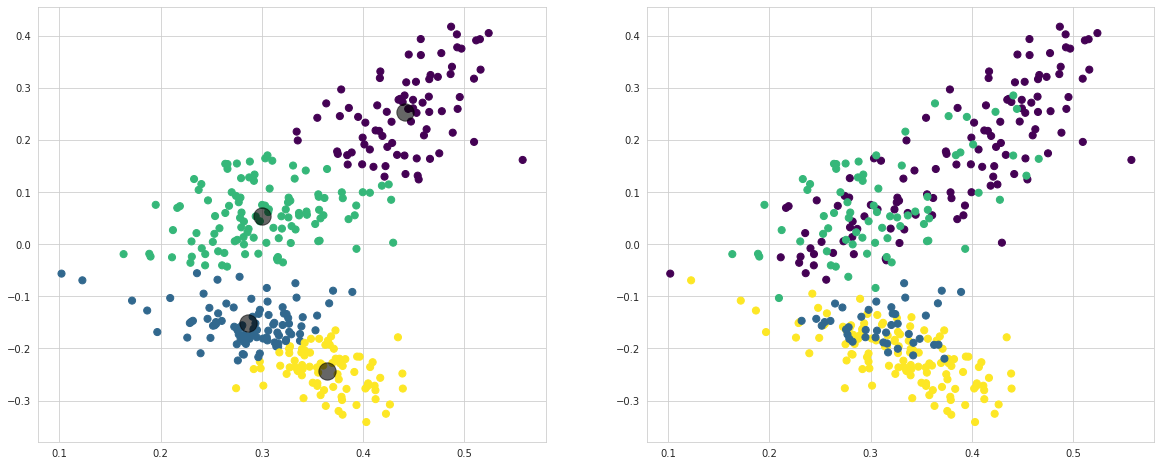

In [43]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))

axes[0].scatter(Y_sklearn[:, 0], Y_sklearn[:, 1], c=plot_df['svd_labels'], s=50, cmap='viridis')

centers = svd_km.cluster_centers_
axes[0].scatter(centers[:, 0], centers[:, 1],c='black', s=300, alpha=0.6);

axes[1].scatter(Y_sklearn[:, 0], Y_sklearn[:, 1], c=plot_df['transformed_id'], s=50, cmap='viridis')



In [61]:
import plotly.express as px
fig = px.scatter_3d(plot_df, x='Z_1', y='Z_2', z='Z_3',
              color='transformed_id')
fig.show()


In [62]:
import plotly.express as px
fig = px.scatter_3d(plot_df, x='Z_1', y='Z_2', z='Z_3',
              color='svd_labels')
fig.show()

In [ ]:
import warnings
warnings.simplefilter("ignore", DeprecationWarning)
# Load the LDA model from sk-learn
from sklearn.decomposition import LatentDirichletAllocation as LDA
 
# Helper function
def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
        
# Tweak the two parameters below
number_topics = 2
number_words = 100
# Create and fit the LDA model
lda = LDA(n_components=number_topics, n_jobs=-1)
lda.fit(count_data)
# Print the topics found by the LDA model
print("Topics found via LDA:")
print_topics(lda, count_vectorizer, number_words)

Topics found via LDA:

Topic #0:
went did came bull looked man old jack thought saw water fish people just room table little head face knew dark great sat got says turned door road looking time thing walked street wine wind stood make big eyes say white bed look felt manuel maybe hotel going _gran long maestro_ light crowd wish open high romero brought trees far day boy bulls stopped heard sun hit country ring men course watched quite car square sitting inside hands half dead xe9 standing bar line forward caf called passed close portrait smiled fast leaned ahead straight stairs cape end hot gone

Topic #1:
said colonel good know like don brett right think asked want come dont tell yes hand thought ll mike going way time just let hell girl love cohn got left night oh town drink better away boy man say started feel long ve took told sure old morning talk nice bad things really jake wanted line manuel ill robert coming eat sleep waiter make remember try seen big money look boat fish talki

In [ ]:
!pip install pyLDAvis

     |████████████████████████████████| 1.6MB 2.8MB/s 
     |████████████████████████████████| 552kB 17.9MB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-2.1.2-py2.py3-none-any.whl size=97712 sha256=ebf6b633f128af6fe903124a58a04d451673db3737800c7c2244fd04bfbdfc72
  Stored in directory: /root/.cache/pip/wheels/98/71/24/513a99e58bb6b8465bae4d2d5e9dba8f0bef8179e3051ac414
  Created wheel for funcy: filename=funcy-1.14-py2.py3-none-any.whl size=32042 sha256=268e1b8610ab2f0d5e5211e6d74eb7fd58b7964800cbde360e26c74f49ec7549
  Stored in directory: /root/.cache/pip/wheels/20/5a/d8/1d875df03deae6f178dfdf70238cca33f948ef8a6f5209f2eb
Successfully built pyLDAvis funcy


In [ ]:
from pyLDAvis import sklearn as sklearn_lda
import pickle 
import pyLDAvis
import os
LDAvis_data_filepath = os.path.join('./ldavis_prepared_'+str(number_topics))
# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
#if 1 == 1:
LDAvis_prepared = sklearn_lda.prepare(lda, count_data, count_vectorizer)
#with open(LDAvis_data_filepath, 'w') as f:
#  pickle.dump(LDAvis_prepared, f)
        
# load the pre-prepared pyLDAvis data from disk
#with open(LDAvis_data_filepath) as f:
#    LDAvis_prepared = pickle.load(f)


In [ ]:
pyLDAvis.save_html(LDAvis_prepared, './ldavis_prepared_'+ str(number_topics) +'.html')


In [ ]:
from google.colab import files
files.download('ldavis_prepared_2.html') 


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>